In [19]:
# Cell 1: Import necessary libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
import time
from progress.bar import IncrementalBar

# Custom modules (assuming they are in the same directory or properly installed as packages)
from dataset import Cityscapes, Facades, Maps, PM25
from dataset import transforms as T
from gan.generator import UnetGenerator
from gan.discriminator import ConditionalDiscriminator
from gan.criterion import GeneratorLoss, DiscriminatorLoss
from gan.utils import Logger, initialize_weights

In [2]:
# Cell 2: Define parameters (replacing argparse)
epochs = 5  # Number of epochs
dataset_name = "facades"  # Name of the dataset: ['facades', 'maps', 'cityscapes']
batch_size = 1  # Size of the batches
learning_rate = 0.01  # Adam's learning rate 0.0002

In [20]:
# Cell 3: Set up device and transformations
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')

transforms = T.Compose([T.Resize((256, 256)),
                        T.ToTensor(),
                        T.Normalize(mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5])])


In [21]:
# Cell 4: Define models, optimizers, and loss functions
print('Defining models!')
generator = UnetGenerator().to(device)
discriminator = ConditionalDiscriminator().to(device)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

g_criterion = GeneratorLoss(alpha=100)
d_criterion = DiscriminatorLoss()

Defining models!


In [22]:
# Cell 5: Load the dataset
print(f'Downloading "{dataset_name.upper()}" dataset!')
if dataset_name == 'cityscapes':
    dataset = Cityscapes(root='.', transform=transforms, download=True, mode='train')
elif dataset_name == 'maps':
    dataset = Maps(root='.', transform=transforms, download=True, mode='train')
else:
    dataset = Facades(root='.', transform=transforms, download=True, mode='train')

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Dataset is already downloaded!


In [23]:
dataset

In [24]:
# Cell 6: Training loop
print('Start of training process!')
logger = Logger(filename=dataset_name)
for epoch in range(epochs):
    ge_loss = 0.
    de_loss = 0.
    start = time.time()
    bar = IncrementalBar(f'[Epoch {epoch+1}/{epochs}]', max=len(dataloader))
    for x, real in dataloader:
        x = x.to(device)
        real = real.to(device)

        # Generator's loss
        fake = generator(x)
        fake_pred = discriminator(fake, x)
        g_loss = g_criterion(fake, real, fake_pred)

        # Discriminator's loss
        fake = generator(x).detach()
        fake_pred = discriminator(fake, x)
        real_pred = discriminator(real, x)
        d_loss = d_criterion(fake_pred, real_pred)

        # Generator's params update
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Discriminator's params update
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Add batch losses
        ge_loss += g_loss.item()
        de_loss += d_loss.item()
        bar.next()
    bar.finish()  

    # Obtain per epoch losses
    g_loss = ge_loss / len(dataloader)
    d_loss = de_loss / len(dataloader)

    # Count timeframe
    end = time.time()
    tm = (end - start)
    logger.add_scalar('generator_loss', g_loss, epoch+1)
    logger.add_scalar('discriminator_loss', d_loss, epoch+1)
    logger.save_weights(generator.state_dict(), 'generator')
    logger.save_weights(discriminator.state_dict(), 'discriminator')
    print("[Epoch %d/%d] [G loss: %.3f] [D loss: %.3f] ETA: %.3fs [Device: %s]" % (epoch+1, epochs, g_loss, d_loss, tm, x.device))
logger.close()
print('End of training process!')

Start of training process!
[Epoch 1/5] [G loss: 41.467] [D loss: 0.276] ETA: 14.766s [Device: cuda:0]
[Epoch 2/5] [G loss: 40.838] [D loss: 0.258] ETA: 14.241s [Device: cuda:0]
[Epoch 3/5] [G loss: 40.703] [D loss: 0.288] ETA: 14.165s [Device: cuda:0]
[Epoch 4/5] [G loss: 40.677] [D loss: 0.306] ETA: 14.119s [Device: cuda:0]
[Epoch 5/5] [G loss: 40.434] [D loss: 0.288] ETA: 14.156s [Device: cuda:0]
End of training process!


In [25]:
# print current working directory
import os
print(os.getcwd())

e:\Coding\pix2pix_pytorch


In [26]:
# Cell 7: Load the saved model weights
# Define the paths where the model weights are saved

generator_weights_path = os.getcwd()+'/runs/generator.pt'
discriminator_weights_path = os.getcwd()+'/runs/discriminator.pt'

# Load the saved weights
generator.load_state_dict(torch.load(generator_weights_path))
discriminator.load_state_dict(torch.load(discriminator_weights_path))
print("Model weights loaded successfully!")

Model weights loaded successfully!


Dataset is already downloaded!


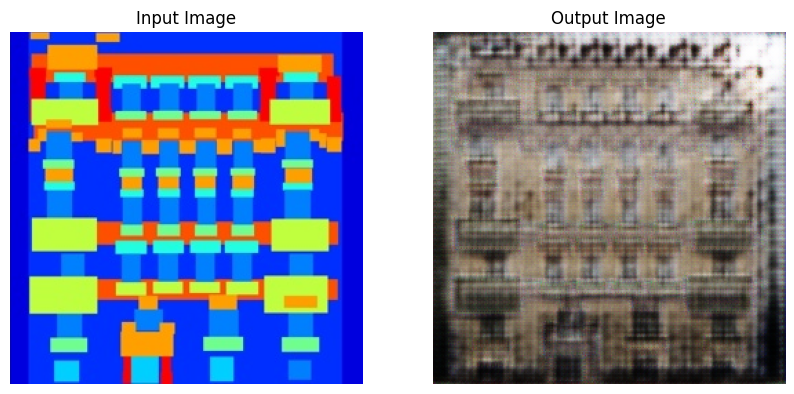

In [29]:
# Cell 8: Run the model on test data and print predictions
import matplotlib.pyplot as plt
import numpy as np

def imshow(tensor, title=None, ax=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)  # remove the batch dimension
    image = image.numpy().transpose((1, 2, 0))  # convert to HWC
    image = image * 0.5 + 0.5  # unnormalize
    if ax is None:
        ax = plt.gca()
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')

# Load some test data
dataset = Facades(root='.', transform=transforms, download=True, mode='test')
test_loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Get a batch of test data
data_iter = iter(test_loader)
inputs, _ = next(data_iter)  # Use the built-in next() function
inputs = inputs.to(device)

# Generate predictions
with torch.no_grad():
    outputs = generator(inputs)

# Plot the input and output images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
imshow(inputs[0], title='Input Image', ax=ax[0])
imshow(outputs[0], title='Output Image', ax=ax[1])
plt.show()